In [63]:
# Imports
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

In [2]:
excel = pd.ExcelFile("European attitudes towards energy policies_SP555_VOL_A.xlsx")
excel_name = "VOL_A"
print(excel.sheet_names)

#excel= data.iloc[8:]
#print(excel)
#print(data.iloc[5])


['Content', 'B', 'QC1', 'QC2', 'QC2T', 'QC3_1', 'QC3_2', 'QC3_3', 'QC3_4', 'QC3_5', 'QC4a', 'QC4b', 'QC4T', 'QC5a', 'QC5b', 'QC5T', 'QC6', 'QC7', 'QC8_1', 'QC8_2', 'QC8_3', 'QC9', 'QC9a', 'QC9b', 'QC10', 'QC10T', 'QC11', 'QC11T', 'QC12', 'QC12T', 'D15a', 'D15a_2', 'C14', 'D15b', 'D15b_2', 'SD28', 'SD29', 'D11', 'D11R', 'D7', 'D7R', 'D8', 'D8c', 'D10', 'D25', 'D40a', 'D40b', 'D40c', 'D40', 'D40R', 'D60', 'D62_1', 'D62_2', 'D62_3', 'D62_4', 'D62R', 'D63', 'D70', 'D70a', 'D1', 'D1_2', 'D1_3', 'D71_1', 'D71_2', 'D71_3', 'C2', 'D78', 'D73_1', 'D73_2', 'D73_3', 'SD18a', 'SD18b', 'D72_1', 'D72_2', 'SD20']


In [3]:
# read specific sheet, without columns set, since column names change in the sheet
sheet_names = ['QC1', 'QC2', 'QC2T', 'QC3_1', 'QC3_2', 'QC3_3', 'QC3_4', 'QC3_5', 'QC4a', 'QC4b', 'QC4T', 'QC5a', 'QC5b', 'QC5T', 'QC6', 'QC7', 'QC8_1', 'QC8_2', 'QC8_3', 'QC9', 'QC9a', 'QC9b', 'QC10', 'QC10T', 'QC11', 'QC11T', 'QC12', 'QC12T']

In [31]:
def preprocessing(sheet):
    # QUESTIONS FILTERING
    questions = sheet.iloc[8:, 1:2].reset_index(drop=True)
    rows_to_drop = [0,2]  # The 10th row becomes index 1 after slicing
    questions = questions.drop(index=rows_to_drop).reset_index(drop=True)
    questions_eng = questions.iloc[::2].reset_index(drop=True) # drop every second row (french questions)
    questions_eng = questions_eng.drop(index=0).reset_index(drop=True) # drop total values row
    #print(questions.columns)
    #print("questions English Shape:", questions_eng.shape)
    #print("questions English:", questions_eng)

    # DATA FILTERING
    data = sheet.iloc[8:, 2:].reset_index(drop=True)
    #print(data.iloc[0:3,:])
    data = data.drop(index=2).reset_index(drop=True) #NaN values
    #print(data.iloc[0])
    data.columns = data.iloc[0]
    data = data[1:].reset_index(drop=True)
    data_percent = data.iloc[::2].reset_index(drop=True) # drop every second row (absoute values)
    data_percent = data_percent.drop(index=0).reset_index(drop=True) # drop total values row
    data_percent.replace("-", 0, inplace=True)
    #print(data.columns)
    #print("data percentages shape:",data_percent.shape)
    #print("data percentages:", data_percent)
    #print(data["UE27\nEU27"])
    return questions_eng, data_percent

In [5]:
def concat_df(questions_eng_df, data_percent_df):
    QC1_df = pd.concat([questions_eng_df, data_percent_df], axis=1)
    QC1_df = QC1_df.rename(columns={QC1_df.columns[0]: "Question"})
    return QC1_df


# PCA of Questions

In [6]:
# Standardize the data
def get_pca_data(data_percent, questions, sheet, volumne):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_percent)

    # Apply PCA
    pca = PCA(n_components=2)  # Top 2 components for simplicity
    pca_result = pca.fit_transform(data_scaled)
    #print(pca_result.shape)
    #print(pca_result)

    # Create a DataFrame with the results
    pca_df = pd.DataFrame(data=pca_result, columns=["PC1", "PC2"])

    # Add the questions back to the PCA dataframe
    #pca_df["Question"] = questions["Question"]
    pca_df["Countries"] = data_percent.T.columns

    #pca_df.to_csv("pca_data/PCA"+volumne+"_"+sheet)
    return pca_df



# Extract Questions

In [ ]:

"""
def preprocessing_questions(sheet):
    questions = sheet.iloc[6:,2:3].reset_index(drop=True) # remove first six rows, keep only third column
    questions[['Part1', 'Part2']] = questions[2].str.split('.', n=1, expand=True)
    print(questions.columns)
    print(questions["Part2"])

all_questions = pd.DataFrame()
sheet = pd.read_excel(excel, sheet_name="Content", header=None)
questions = preprocessing_questions(sheet=sheet)
questions["Part1", "Part2"].to_csv("src/data/questions")
"""
# Define output file path
output_file_path = "src/data/questions.csv"

# Function to split the question ID and text
def split_question_id(question):
    # Match IDs like QC12, QC8.3., QC4a., capturing groups
    match = re.match(r'^(QC\d+[a-zA-Z]?)(?:\.(\d+[a-zA-Z]?)?)?\.?(.*)$', str(question))
    if match:
        part1 = match.group(1)  # Main ID (e.g., QC8, QC4a)
        part2 = match.group(2) if match.group(2) else ""  # Sub-part (e.g., 3, 3a)
        remaining_text = match.group(3).strip() if match.group(3) else ""  # Remaining text (if any)
        return pd.Series([part1, part2, remaining_text])
    # Fallback for unexpected formats
    return pd.Series([question, "", ""])

# Function to preprocess questions from a sheet
def preprocess_questions(sheet):
    # Extract rows starting from the 7th row (index 6) and the third column (index 2)
    questions = sheet.iloc[6:, 2].reset_index(drop=True)
    # Create a DataFrame for raw questions
    questions = questions.to_frame(name='Raw_Question')
    # Apply split_question_id and create columns for ID, SubID, and Question_Text
    questions[['ID', 'SubID', 'Question_Text']] = questions['Raw_Question'].apply(split_question_id)
    return questions[['ID', 'SubID', 'Question_Text']]

# Read Excel sheet
sheet = pd.read_excel(excel, sheet_name="Content", header=None)

# Preprocess the questions
processed_questions = preprocess_questions(sheet=sheet)

# Save the processed questions to a CSV file
processed_questions.to_csv(output_file_path, index=False)
print(f"Questions successfully saved to {output_file_path}")


Questions successfully saved to src/data/questions.csv


# Extract Data

In [12]:
#all_pca_question_df = []
all_pca_countries_df = []
all_questions_and_answers= []
for i in range(len(sheet_names)):
    sheet = pd.read_excel(excel, sheet_name=sheet_names[i], header=None)
    questions_engl, data_percent = preprocessing(sheet)
    all_questions_and_answers.append(questions_engl)
    data_concat = concat_df(questions_eng_df= questions_engl, data_percent_df= data_percent)
    #print(data_concat.columns)
    #pca_questions_df = pca_questions(data_percent, data_concat, sheet_names[i], volumne=excel_name)
    
    data = data_percent.T
    #print(data)
    pca_countries_df = get_pca_data(data, data_concat, sheet_names[i], volumne=excel_name)
    #print(pca_countries_df)
    #all_pca_question_df.append(pca_questions_df)
    all_pca_countries_df.append(pca_countries_df)
#all_questions_and_answers = pd.DataFrame(all_questions_and_answers)
print(all_questions_and_answers[0])
#all_questions_and_answers.to_csv("src/data/questions")
#print(len(all_pca_countries_df))    
    


C:\Users\Elena\AppData\Local\Temp\ipykernel_13316\2943435873.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  QC1_data_percent.replace("-", 0, inplace=True)
C:\Users\Elena\AppData\Local\Temp\ipykernel_13316\2943435873.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  QC1_data_percent.replace("-", 0, inplace=True)
C:\Users\Elena\AppData\Local\Temp\ipykernel_13316\2943435873.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly cal

[                                                    1
0   Coordinating European countries on energy matters
1   Improving energy infrastructure between and ac...
2   Preventing electricity black-outs and energy s...
3                 Driving European climate neutrality
4   Decreasing energy consumption across Europe - ...
5          Ensuring nuclear energy is safe and secure
6   Supporting countries outside the European Unio...
7         Investing in innovative energy technologies
8   Ensuring more affordable energy prices for con...
9                                 Other (SPONTANEOUS)
10                    Prefer not to say (SPONTANEOUS)
11                                         Don't know,                                                    1
0  Yes, it should have more coordinated and integ...
1  Yes, it should have more coordination, but onl...
2          Yes, but only when justified by a crisis 
3  No, the current level of coordination is adequate
4  No, European Union should no

C:\Users\Elena\AppData\Local\Temp\ipykernel_13316\2943435873.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  QC1_data_percent.replace("-", 0, inplace=True)
C:\Users\Elena\AppData\Local\Temp\ipykernel_13316\2943435873.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  QC1_data_percent.replace("-", 0, inplace=True)
C:\Users\Elena\AppData\Local\Temp\ipykernel_13316\2943435873.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly cal

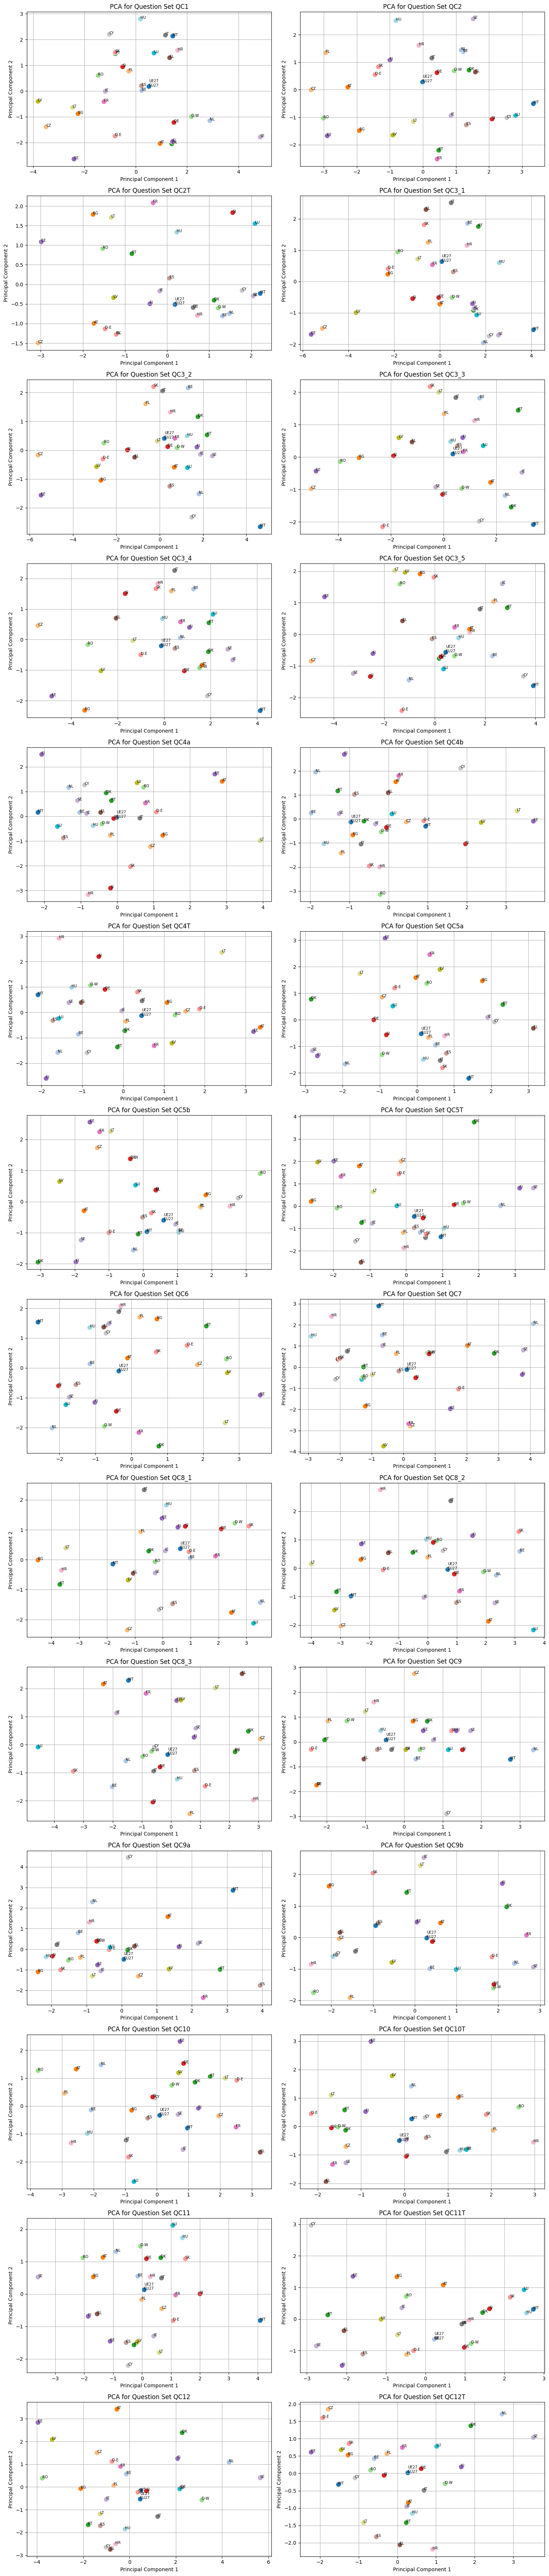

In [45]:
#print(all_pca_question_df)
pca_data = all_pca_countries_df
# Determine subplot grid size
num_plots = len(pca_data)
cols = 2  # Define number of columns
rows = (num_plots // cols) + (num_plots % cols > 0)  # Calculate rows dynamically

plt.figure(figsize=(15, 5 * rows))  # Adjust height based on number of rows

for i, pca_df in enumerate(pca_data):  # Enumerate for index and dataframe
    
    plt.subplot(rows, cols, i + 1)  # Create subplot (1-based index)
    
    # Scatter plot of PC1 vs PC2
    sns.scatterplot(x=pca_df["PC1"], y=pca_df["PC2"], hue=pca_df["Countries"], 
                    palette="tab20", s=100, legend=False)

    # Add labels, title, and grid
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title(f"PCA for Question Set {sheet_names[i]}")
    plt.grid(True)

    # Adjust legend
    #plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=1, fontsize='small')
    for i in range(pca_df.shape[0]):
        plt.text(pca_df["PC1"][i], pca_df["PC2"][i], pca_df["Countries"][i], fontsize=7)

plt.tight_layout()  # Avoid overlapping
plt.show()
